# 네이버 영화리뷰 감성분석 

## Data set = Movie reply from Naver

## 루브릭

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.

3가지 이상의 모델이 성공적으로 시도됨

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.

네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함


In [146]:
#Data set 
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


<순서>

데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴


In [147]:

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'],inplace=True)
    train_data =  train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        t_X = tokenizer.morphs(sentence)#토크나이저 적용
        t_X = [word for word in t_X if not word in stopwords]#불용어 제거
        X_train.append(t_X)
        
    X_test = []
    for sentence in test_data['document']:
        t_X = tokenizer.morphs(sentence)#토크나이저 적용
        t_X = [word for word in t_X if not word in stopwords]#불용어 제거
        X_test.append(t_X)
        
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))


훈련 샘플 개수: 146182, 테스트 개수: 49157


In [148]:
#text,index key value 위치 변경
index_to_word = {index:word for word, index in word_to_index.items()}


In [149]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 모델구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [150]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))



문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [151]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [154]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 모델설계

In [155]:
# simple GlobalMaxPooling1D Model

vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model1= keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [156]:
# conv1D+ CNN Model

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [ ]:
# RNN LSTM

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [157]:
# 데이터 축소
# validation set 100000건 분리 
x_val = X_train[:100000]   
y_val = y_train[:100000]

# validation set을 제외한 나머지 50000건
partial_x_train = X_train[100000:]  
partial_y_train = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(46182, 41)
(46182,)


In [170]:
from keras.callbacks import EarlyStopping

#model 1 학습
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
#                     callbacks=[early_stopping], #epoch 효율을 위해 earlyStopping setting
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
91/91 [==============================] - 1s 9ms/step - loss: 0.1659 - accuracy: 0.9391 - val_loss: 0.4598 - val_accuracy: 0.8264
Epoch 2/20
91/91 [==============================] - 1s 8ms/step - loss: 0.1578 - accuracy: 0.9434 - val_loss: 0.4740 - val_accuracy: 0.8250
Epoch 3/20
91/91 [==============================] - 1s 8ms/step - loss: 0.1495 - accuracy: 0.9453 - val_loss: 0.4887 - val_accuracy: 0.8231
Epoch 4/20
91/91 [==============================] - 1s 8ms/step - loss: 0.1384 - accuracy: 0.9510 - val_loss: 0.5058 - val_accuracy: 0.8220
Epoch 5/20
91/91 [==============================] - 1s 8ms/step - loss: 0.1343 - accuracy: 0.9535 - val_loss: 0.5224 - val_accuracy: 0.8198
Epoch 6/20
91/91 [==============================] - 1s 8ms/step - loss: 0.1278 - accuracy: 0.9564 - val_loss: 0.5402 - val_accuracy: 0.8184
Epoch 7/20
91/91 [==============================] - 1s 8ms/step - loss: 0.1201 - accuracy: 0.9601 - val_loss: 0.5592 - val_accuracy: 0.8170
Epoch 8/20
91/91 [==

In [171]:
#모델1 결과

results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.8304 - accuracy: 0.8008
[0.830388605594635, 0.8008422255516052]


In [172]:
#모델2 학습과 결과

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
#                     callbacks=[early_stopping], #epoch 효율을 위해 earlyStopping setting
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0624 - accuracy: 0.9819 - val_loss: 0.8377 - val_accuracy: 0.8018
Epoch 2/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0599 - accuracy: 0.9833 - val_loss: 0.8572 - val_accuracy: 0.8017
Epoch 3/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0574 - accuracy: 0.9833 - val_loss: 0.8784 - val_accuracy: 0.8000
Epoch 4/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0548 - accuracy: 0.9846 - val_loss: 0.8950 - val_accuracy: 0.7996
Epoch 5/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0529 - accuracy: 0.9852 - val_loss: 0.9148 - val_accuracy: 0.7993
Epoch 6/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0506 - accuracy: 0.9858 - val_loss: 0.9322 - val_accuracy: 0.7992
Epoch 7/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0487 - accuracy: 0.9871 - val_loss: 0.9520 - val_accuracy: 0.7984
Epoch 8/20
91/91 [==

In [173]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


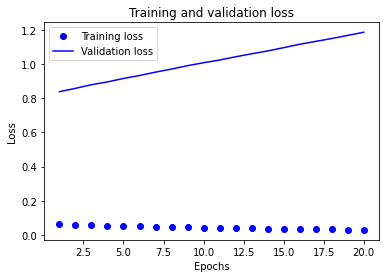

In [175]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

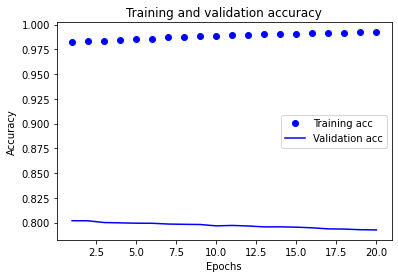

In [176]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Word2Vec 적용

In [179]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [191]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

KeyError: 4

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector